In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from datetime import datetime, timedelta
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [6]:
class ServiceCenterDataGenerator:
    """Generate synthetic service center load data"""
    
    def __init__(self, start_date='2020-01-01', n_records=10000):
        self.start_date = pd.to_datetime(start_date)
        self.n_records = n_records
        self.service_centers = ['SC_North', 'SC_South', 'SC_East', 'SC_West', 'SC_Central']
        
    def generate_data(self):
        """Generate comprehensive service center load data"""
        dates = [self.start_date + timedelta(days=i) for i in range(self.n_records)]
        
        data = []
        for date in dates:
            for center in self.service_centers:
                record = self._generate_daily_record(date, center)
                data.append(record)
        
        df = pd.DataFrame(data)
        print(f"Generated {len(df)} records")
        return df
    
    def _generate_daily_record(self, date, center):
        """Generate single day record for a service center"""
        # Base patterns
        day_of_week = date.dayofweek
        month = date.month
        day_of_year = date.dayofyear
        
        # Fleet size varies by center
        fleet_multiplier = {'SC_North': 1.2, 'SC_South': 1.0, 'SC_East': 0.9, 
                           'SC_West': 1.1, 'SC_Central': 1.3}
        base_fleet = 500 + np.random.randint(-50, 50)
        fleet_size = int(base_fleet * fleet_multiplier[center])
        
        # Seasonal patterns (monsoon = more breakdowns)
        is_monsoon = 1 if month in [6, 7, 8, 9] else 0
        monsoon_factor = 1.5 if is_monsoon else 1.0
        
        # Weekly patterns (lower on weekends)
        weekend_factor = 0.7 if day_of_week >= 5 else 1.0
        
        # Holiday effect (major Indian festivals)
        is_holiday = self._is_holiday(date)
        holiday_factor = 0.5 if is_holiday else 1.0
        
        # Predicted failures (input from maintenance model)
        predicted_failures = np.random.poisson(fleet_size * 0.02 * monsoon_factor)
        
        # Historical appointment trend
        trend = 1 + 0.001 * day_of_year  # Slight upward trend
        
        # Calculate service demand
        base_demand = fleet_size * 0.05  # 5% of fleet needs service daily
        seasonal_component = np.sin(2 * np.pi * day_of_year / 365) * 10
        
        service_demand = (base_demand * monsoon_factor * weekend_factor * 
                         holiday_factor * trend + seasonal_component + 
                         predicted_failures * 0.5)
        
        service_demand = max(int(service_demand + np.random.normal(0, 5)), 0)
        
        # Required resources
        technician_count = max(int(service_demand / 8) + 1, 3)  # 8 services per tech
        parts_inventory = int(service_demand * 2.5)  # Buffer stock
        
        # Actual appointments (with some no-shows)
        actual_appointments = int(service_demand * np.random.uniform(0.85, 1.0))
        
        return {
            'date': date,
            'service_center': center,
            'day_of_week': day_of_week,
            'month': month,
            'day_of_year': day_of_year,
            'fleet_size': fleet_size,
            'is_monsoon': is_monsoon,
            'is_weekend': 1 if day_of_week >= 5 else 0,
            'is_holiday': is_holiday,
            'predicted_failures': predicted_failures,
            'service_demand': service_demand,
            'actual_appointments': actual_appointments,
            'required_technicians': technician_count,
            'required_parts_inventory': parts_inventory,
            'utilization_rate': min(actual_appointments / max(technician_count * 8, 1), 1.0)
        }
    
    def _is_holiday(self, date):
        """Check if date is a major holiday"""
        # Approximate major Indian holidays (simplified)
        holidays = [
            (1, 26),   # Republic Day
            (8, 15),   # Independence Day
            (10, 2),   # Gandhi Jayanti
            (12, 25),  # Christmas
        ]
        # Diwali (approximate - varies by year)
        if date.month == 10 or date.month == 11:
            if np.random.random() < 0.05:
                return 1
        
        return 1 if (date.month, date.day) in holidays else 0

In [7]:
class ServiceLoadLSTM:
    """LSTM model for service center load prediction"""
    
    def __init__(self, lookback=30, forecast_horizon=7):
        self.lookback = lookback
        self.forecast_horizon = forecast_horizon
        self.model = None
        self.scaler = MinMaxScaler()
        self.feature_columns = None
        
    def prepare_sequences(self, df, target_col='service_demand'):
        """Prepare sequences for LSTM training"""
        # Feature engineering
        df = df.sort_values(['service_center', 'date']).reset_index(drop=True)
        
        # Select features
        self.feature_columns = ['day_of_week', 'month', 'day_of_year', 
                               'fleet_size', 'is_monsoon', 'is_weekend', 
                               'is_holiday', 'predicted_failures', 'service_demand']
        
        X_list, y_list = [], []
        
        for center in df['service_center'].unique():
            center_data = df[df['service_center'] == center][self.feature_columns].values
            
            # Normalize
            center_data_scaled = self.scaler.fit_transform(center_data)
            
            # Create sequences
            for i in range(len(center_data_scaled) - self.lookback - self.forecast_horizon + 1):
                X_list.append(center_data_scaled[i:i+self.lookback])
                y_list.append(center_data_scaled[i+self.lookback:i+self.lookback+self.forecast_horizon, -1])
        
        return np.array(X_list), np.array(y_list)
    
    def build_model(self, input_shape):
        """Build advanced LSTM model with attention mechanism"""
        inputs = layers.Input(shape=input_shape)
        
        # LSTM layers with dropout
        x = layers.LSTM(128, return_sequences=True)(inputs)
        x = layers.Dropout(0.2)(x)
        x = layers.LSTM(64, return_sequences=True)(x)
        x = layers.Dropout(0.2)(x)
        
        # Attention mechanism
        attention = layers.Dense(1, activation='tanh')(x)
        attention = layers.Flatten()(attention)
        attention = layers.Activation('softmax')(attention)
        attention = layers.RepeatVector(64)(attention)
        attention = layers.Permute([2, 1])(attention)
        
        x = layers.Multiply()([x, attention])
        x = layers.Lambda(lambda x: tf.reduce_sum(x, axis=1))(x)
        
        # Dense layers
        x = layers.Dense(64, activation='relu')(x)
        x = layers.Dropout(0.2)(x)
        x = layers.Dense(32, activation='relu')(x)
        
        # Output layer
        outputs = layers.Dense(self.forecast_horizon)(x)
        
        model = keras.Model(inputs=inputs, outputs=outputs)
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                     loss='mse',
                     metrics=['mae'])
        
        return model
    
    def train(self, X_train, y_train, X_val, y_val, epochs=50, batch_size=32):
        """Train the LSTM model"""
        self.model = self.build_model((X_train.shape[1], X_train.shape[2]))
        
        print(self.model.summary())
        
        # Callbacks
        early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                    patience=10, 
                                                    restore_best_weights=True)
        reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                       factor=0.5, 
                                                       patience=5, 
                                                       min_lr=0.00001)
        
        history = self.model.fit(X_train, y_train,
                                validation_data=(X_val, y_val),
                                epochs=epochs,
                                batch_size=batch_size,
                                callbacks=[early_stop, reduce_lr],
                                verbose=1)
        
        return history
    
    def predict(self, X):
        """Make predictions"""
        return self.model.predict(X)
    
    def evaluate(self, X_test, y_test):
        """Evaluate model performance"""
        predictions = self.predict(X_test)
        
        mse = np.mean((predictions - y_test) ** 2)
        mae = np.mean(np.abs(predictions - y_test))
        rmse = np.sqrt(mse)
        
        print(f"\nModel Evaluation:")
        print(f"MSE: {mse:.4f}")
        print(f"MAE: {mae:.4f}")
        print(f"RMSE: {rmse:.4f}")
        
        return {'mse': mse, 'mae': mae, 'rmse': rmse}

In [8]:
print("=" * 60)
print("Service Center Load Prediction System")
print("=" * 60)
    
    # Generate data
print("\n1. Generating synthetic service center data...")
generator = ServiceCenterDataGenerator(start_date='2015-01-01', n_records=2200)
df = generator.generate_data()
    
    # Save to data folder
df.to_csv('data/service_center_load_data.csv', index=False)
print(f"   Saved {len(df)} records to data/service_center_load_data.csv")

Service Center Load Prediction System

1. Generating synthetic service center data...
Generated 11000 records
   Saved 11000 records to data/service_center_load_data.csv


In [9]:
print("\n2. Data Sample:")
print(df.head(10))
print(f"\nData shape: {df.shape}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
    
    # Prepare data for LSTM
print("\n3. Preparing sequences for LSTM...")
lstm_model = ServiceLoadLSTM(lookback=30, forecast_horizon=7)
X, y = lstm_model.prepare_sequences(df)
print(f"   X shape: {X.shape}, y shape: {y.shape}")
    
    # Split data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    
print(f"   Train: {X_train.shape[0]}, Val: {X_val.shape[0]}, Test: {X_test.shape[0]}")


2. Data Sample:
        date service_center  day_of_week  month  day_of_year  fleet_size  \
0 2015-01-01       SC_North            3      1            1         601   
1 2015-01-01       SC_South            3      1            1         471   
2 2015-01-01        SC_East            3      1            1         433   
3 2015-01-01        SC_West            3      1            1         564   
4 2015-01-01     SC_Central            3      1            1         678   
5 2015-01-02       SC_North            4      1            2         548   
6 2015-01-02       SC_South            4      1            2         455   
7 2015-01-02        SC_East            4      1            2         477   
8 2015-01-02        SC_West            4      1            2         495   
9 2015-01-02     SC_Central            4      1            2         677   

   is_monsoon  is_weekend  is_holiday  predicted_failures  service_demand  \
0           0           0           0                  13            

In [10]:
 history = lstm_model.train(X_train, y_train, X_val, y_val, epochs=50, batch_size=32)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 30, 9)]              0         []                            
                                                                                                  
 lstm (LSTM)                 (None, 30, 128)              70656     ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 30, 128)              0         ['lstm[0][0]']                
                                                                                                  
 lstm_1 (LSTM)               (None, 30, 64)               49408     ['dropout[0][0]']             
                                                                                             

In [11]:
metrics = lstm_model.evaluate(X_test, y_test)

51/51 [==============================] - 1s 6ms/step

Model Evaluation:
MSE: 0.0089
MAE: 0.0736
RMSE: 0.0943


In [12]:
lstm_model.model.save('weights_and_metadata/service_load_lstm_model.weights.h5')
print("\n6. Model saved ")


6. Model saved 


c:\Users\msaya\Miniconda3\envs\ey2\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



7. Generating sample predictions...
1/1 [==============================] - 0s 26ms/step


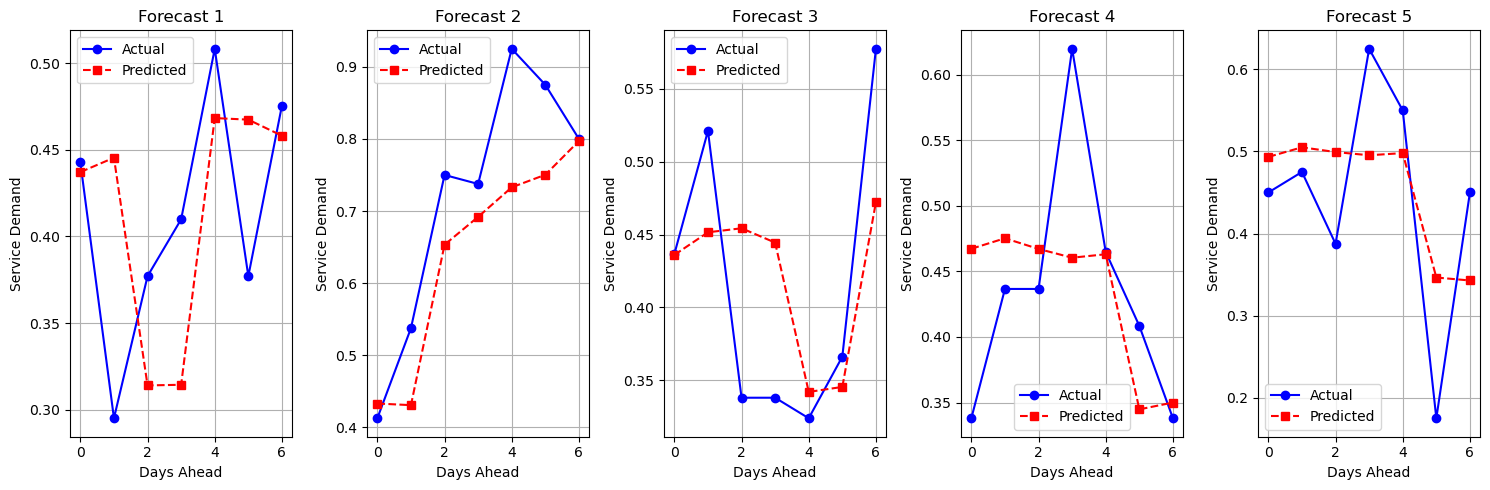

In [13]:
print("\n7. Generating sample predictions...")
sample_pred = lstm_model.predict(X_test[:5])
    
plt.figure(figsize=(15, 5))
for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.plot(range(7), y_test[i], 'b-o', label='Actual')
        plt.plot(range(7), sample_pred[i], 'r--s', label='Predicted')
        plt.title(f'Forecast {i+1}')
        plt.xlabel('Days Ahead')
        plt.ylabel('Service Demand')
        plt.legend()
        plt.grid(True)
    
plt.tight_layout()

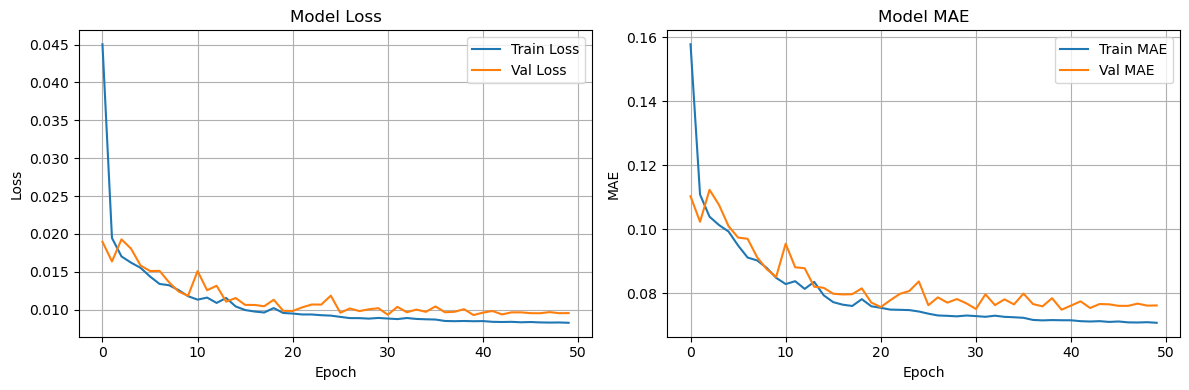

In [14]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
    
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
    
plt.tight_layout()